Bleeping out swear words from audio

Data collection

Mount Drive

In [2]:
!pip install -q gdown

!gdown 1RfE_44oPoFdCth9fu17oevJE31CPYVSa
!gdown 1XaZtTp2WaLtmZtyux3tQIgiDbTUcUF8x

!unzip -o -q 'Swear words.zip' -d '/content'
!unzip -o -q 'Non Swear words.zip' -d '/content'

Downloading...
From: https://drive.google.com/uc?id=1RfE_44oPoFdCth9fu17oevJE31CPYVSa
To: /content/Swear words.zip
100% 7.29M/7.29M [00:00<00:00, 23.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XaZtTp2WaLtmZtyux3tQIgiDbTUcUF8x
To: /content/Non Swear words.zip
100% 3.51M/3.51M [00:00<00:00, 302MB/s]


In [3]:
# !pip install sounddevice
# !sudo apt-get install portaudio19-dev


Import relevant libraries

In [4]:
import os
import shutil
import random
import librosa
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


from pathlib import Path
from IPython.display import Audio

Copy Data to Colab

DATA PREPROCESSING

Build feature extraction pipeline.

In [5]:
def plot_specgram(S, fs, window_length, overlap, nfft, save=False):
    librosa.display.specshow(
        S, sr=fs, hop_length=window_length-overlap, n_fft=nfft,
        win_length=window_length, y_axis='log', x_axis='time'
        )

    if not save:
        # plt.title("Log-frequency power spectrogram")
        # plt.show()
        pass


def obtain_specgram(
    filepath, window_length, overlap, plot=False, save=False, save_dir=None
    ):
    '''This function returns the normalized power spectrogram of a audio'''
    audio,fs = librosa.load(filepath)

    window_length = int(window_length/1000*fs)
    overlap = int(overlap * window_length)
    nfft = 2**(int(np.log2(window_length)) + 1)

    S = librosa.stft(
        audio, n_fft=nfft, hop_length=window_length-overlap,
        win_length=window_length
        )
    
    S = np.abs(S)**2
    S = librosa.power_to_db(S, ref=np.max(S))
    S = np.clip(S, -40, -3)

    if plot:
        plot_specgram(S, fs, window_length, overlap, nfft, save)
    
    if save:
        plt.axis('off')
        plt.savefig(save_dir)

    return S

In [6]:
my_list = ['/content/Non Swear words', 
           '/content/Swear words',]

for folder in my_list:
    # folder_name = os.path.basename(folder)
    print(folder)

/content/Non Swear words
/content/Swear words


Extract spectrograms for each audio file

rm: cannot remove '/content/generated_spectrograms': No such file or directory
Non Swear words
/content/generated_spectrograms/Non Swear words/Bald.png
/content/generated_spectrograms/Non Swear words/0c2d2ffa_nohash_0 (1).png
/content/generated_spectrograms/Non Swear words/016e2c6d_nohash_0.png
/content/generated_spectrograms/Non Swear words/01d22d03_nohash_0 (1).png
/content/generated_spectrograms/Non Swear words/0bd689d7_nohash_0.png
/content/generated_spectrograms/Non Swear words/00f0204f_nohash_0.png
/content/generated_spectrograms/Non Swear words/0132a06d_nohash_1 (1).png
/content/generated_spectrograms/Non Swear words/0132a06d_nohash_0.png
/content/generated_spectrograms/Non Swear words/1365dd89_nohash_0.png
/content/generated_spectrograms/Non Swear words/096456f9_nohash_0.png
/content/generated_spectrograms/Non Swear words/0132a06d_nohash_2 (1).png
/content/generated_spectrograms/Non Swear words/129c7d8d_nohash_0.png
/content/generated_spectrograms/Non Swear words/004ae714_nohas

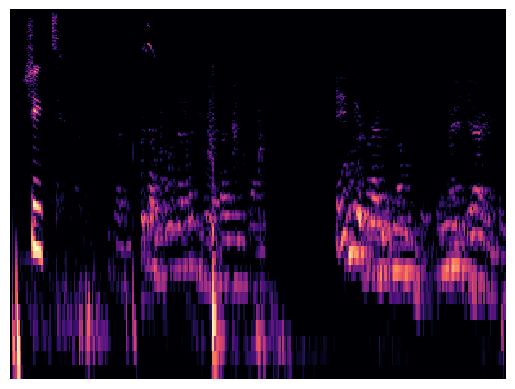

In [7]:
dataset_folder = pathlib.Path("/content/")
specgram_folder = pathlib.Path("/content/generated_spectrograms")

!rm -r "{specgram_folder}"
os.mkdir(specgram_folder)

window_length = 40   # 40ms
overlap = 0.5        # 50%

# for folder in dataset_folder.glob('*'):
#     folder_name = os.path.basename(folder)
#     print(folder_name)

for folder in my_list:
    folder = pathlib.Path(folder)
    folder_name = os.path.basename(folder)
    print(folder_name)

    try:
        os.mkdir(f"{str(specgram_folder)}/{folder_name}")
    except:
        pass

    for i,audio in enumerate(folder.glob('*')):
        if audio.is_dir():
            continue
        
        save_path = str(audio).replace('wav', 'png')
        save_path = save_path.replace(str(dataset_folder), str(specgram_folder))
        print(save_path)
        obtain_specgram(audio, window_length, overlap, plot=True, save=True, save_dir=save_path)

Plot Sample spectrogram

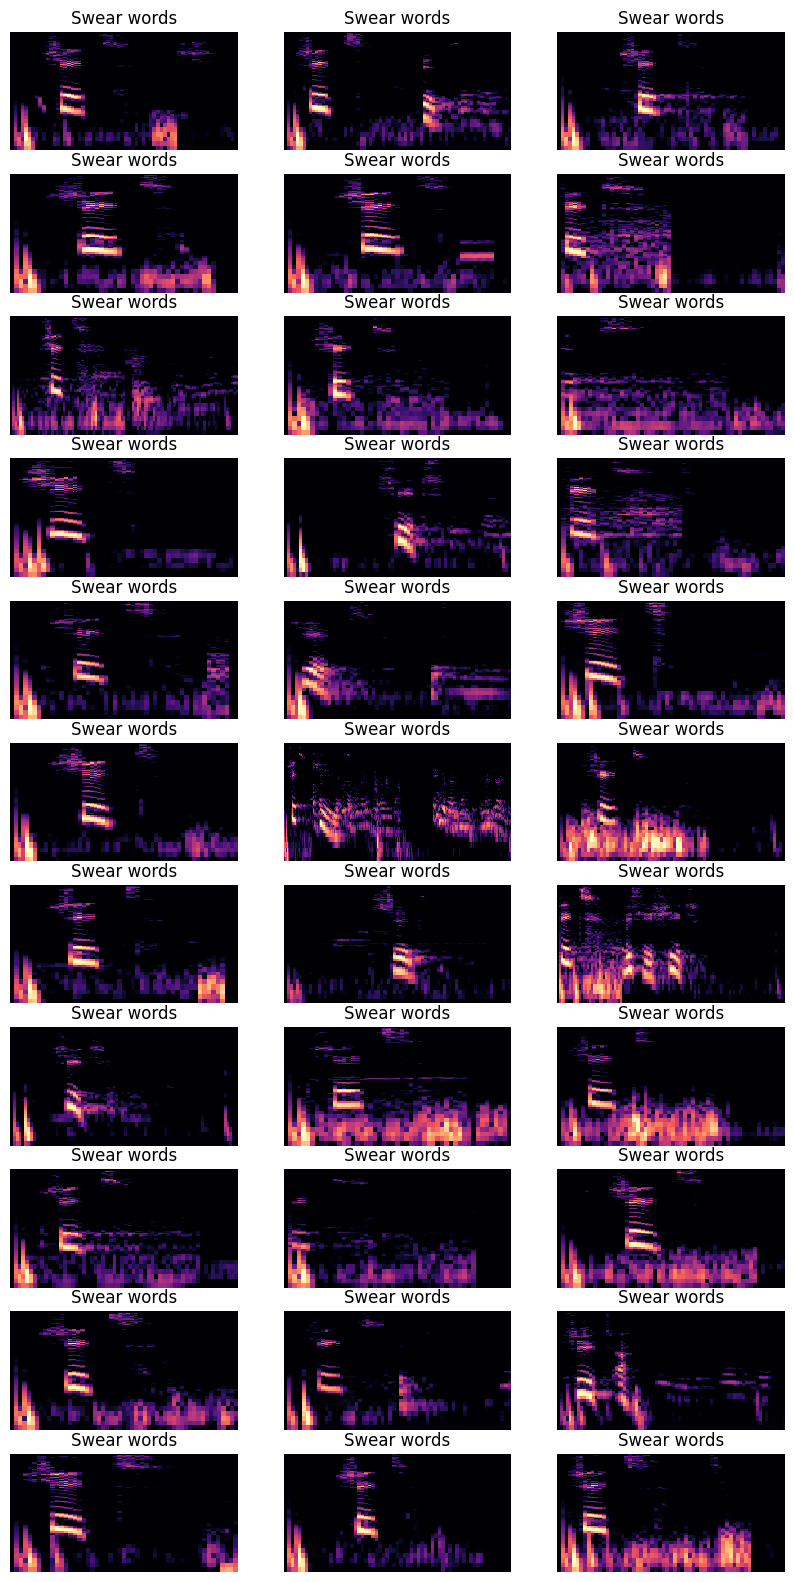

In [8]:
window_length = 40   # 40ms
overlap = 0.5        # 50%

plt.figure(figsize=(10, 20))

i = 0
# for folder in dataset_folder.glob('*'):
#     folder_name = os.path.basename(folder)
for folder in my_list:
    folder = pathlib.Path(folder)
    folder_name = os.path.basename(folder)
    # print(folder_name)

    
    for j,audio in enumerate(folder.glob('*')):
        # if audio.is_dir():
        #     continue
        
        ax = plt.subplot(11, 3, i %33 + 1)
        obtain_specgram(audio, window_length, overlap, plot=True,)
        plt.title(folder_name)
        plt.axis("off")

        i += 1     
plt.show()


Split data

In [9]:
import os
import shutil
import random
import pathlib

specgram_folder = pathlib.Path("/content/generated_spectrograms")

print("Splitting data...")
print("---" * 15)

train_dir = pathlib.Path("/content/generated_spectrograms/train")
val_dir = pathlib.Path("/content/generated_spectrograms/validation")
test_dir = pathlib.Path("/content/generated_spectrograms/test")

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(val_dir):
    os.mkdir(val_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

for folder in specgram_folder.glob('*'):
    folder_name = os.path.basename(folder)

    if folder_name not in ["train", "validation", "test"]:
        print(folder)

        if not os.path.exists(os.path.join(train_dir, folder_name)):
            os.mkdir(os.path.join(train_dir, folder_name))

        if not os.path.exists(os.path.join(val_dir, folder_name)):
            os.mkdir(os.path.join(val_dir, folder_name))

        if not os.path.exists(os.path.join(test_dir, folder_name)):
            os.mkdir(os.path.join(test_dir, folder_name))

        specgrams = os.listdir(folder)
        random.shuffle(specgrams)

        train = specgrams[:int(0.7 * len(specgrams))]
        val = specgrams[int(0.7 * len(specgrams)):int(0.85 * len(specgrams))]
        test = specgrams[int(0.85 * len(specgrams)):]

        for specgram in train:
            dst = os.path.join(train_dir, folder_name, specgram)
            src = os.path.join(folder, specgram)
            shutil.copy(src, dst)

        for specgram in val:
            dst = os.path.join(val_dir, folder_name, specgram)
            src = os.path.join(folder, specgram)
            shutil.copy(src, dst)

        for specgram in test:
            dst = os.path.join(test_dir, folder_name, specgram)
            src = os.path.join(folder, specgram)
            shutil.copy(src, dst)

print("---" * 15)
print("Done!")


Splitting data...
---------------------------------------------
/content/generated_spectrograms/Swear words
/content/generated_spectrograms/Non Swear words
---------------------------------------------
Done!


In [10]:
print(f"train_dir: {train_dir}")
print(f"val_dir: {val_dir}")
print(f"test_dir: {test_dir}")

train_dir: /content/generated_spectrograms/train
val_dir: /content/generated_spectrograms/validation
test_dir: /content/generated_spectrograms/test


In [11]:
import os

folder_path = "/content/generated_spectrograms/train/Swear words"  # Replace with the actual path to your folder

# Get the list of files in the folder
files = os.listdir(folder_path)

# Count the number of files
num_files = len(files)

# Print the number of files
print("Number of files in the folder:", num_files)

Number of files in the folder: 64


Develop machine learning model

Define dataset generators

In [12]:
batch_size = 64

# flow_from_directory gets label for an image from the sub-directory it is placed in
# Generate Train data
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/generated_spectrograms/train',
    batch_size=32
    )

# Generate Validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/generated_spectrograms/validation',
    batch_size=32,
    )

# Generate Test data
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/generated_spectrograms/test',
    batch_size=32,
    )

Found 128 files belonging to 2 classes.
Found 28 files belonging to 2 classes.
Found 28 files belonging to 2 classes.


In [13]:
import os

# Function to print filenames and labels in a directory
def print_filenames_and_labels(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            label = os.path.basename(root)
            print("File:", file_path, "| Label:", label)

# Print filenames and labels in train directory
print("Train directory:")
print_filenames_and_labels('/content/generated_spectrograms/train')

# Print filenames and labels in validation directory
print("Validation directory:")
print_filenames_and_labels('/content/generated_spectrograms/validation')

# Print filenames and labels in test directory
print("Test directory:")
print_filenames_and_labels('/content/generated_spectrograms/test')


Train directory:
File: /content/generated_spectrograms/train/Swear words/Makerere University 26.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/7.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/Makerere University 52.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/Makerere University 30.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/10.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/Makerere University 60.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/27.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/21.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/Makerere University 34.png | Label: Swear words
File: /content/generated_spectrograms/train/Swear words/9.png | Label: Swear words
File: /content/generated_spectrograms/train/S

Class name

In [14]:
# Class names
class_names = train_ds.class_names
print(class_names)

['Non Swear words', 'Swear words']


In [15]:
train_ds.cardinality().numpy()

4

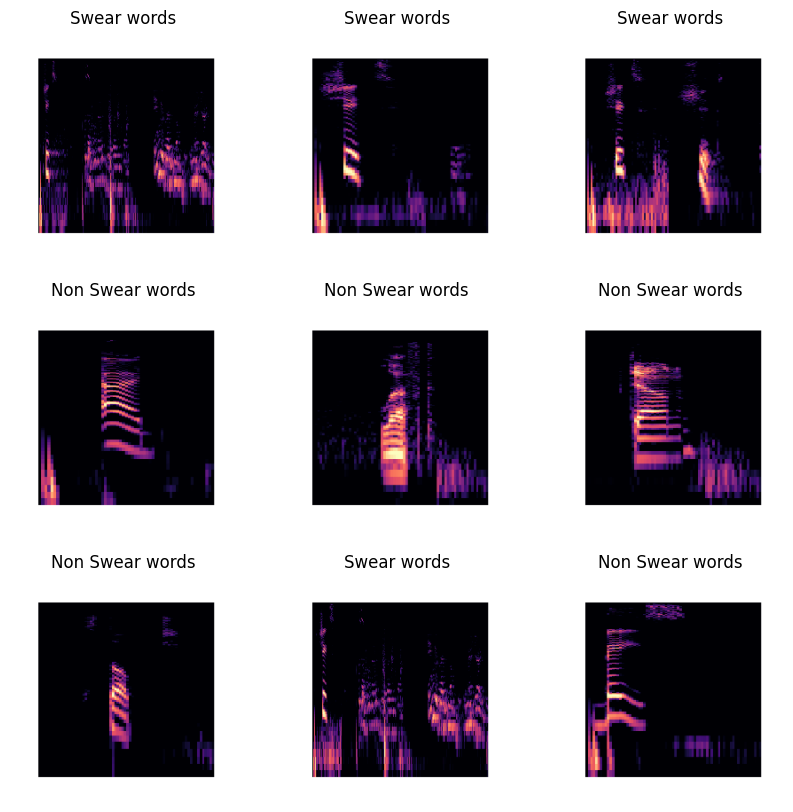

In [16]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
# Shapes of the dataset generators
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Define model Architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9

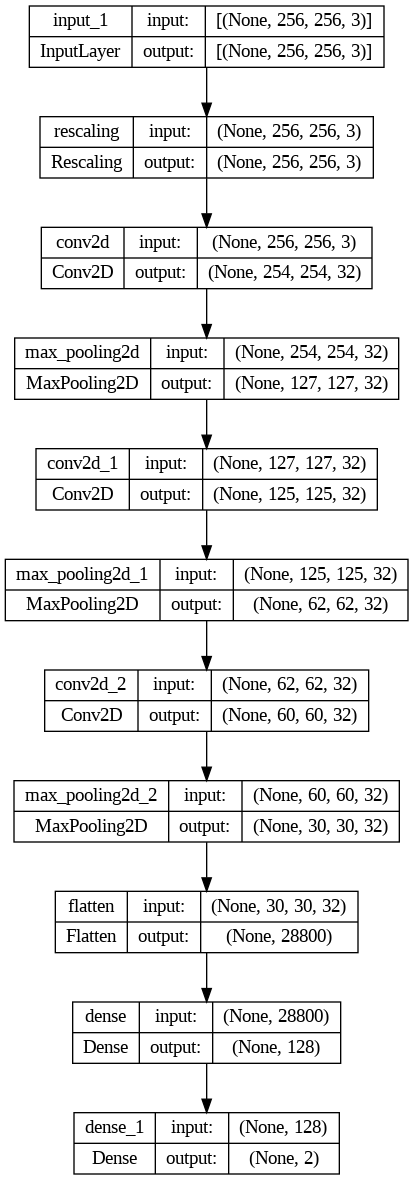

In [19]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(256, 256,3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=10)

Epoch 1/10
4/4 [==============================] - 13s 414ms/step - loss: 1.0034 - accuracy: 0.4844 - val_loss: 0.6754 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 0s 51ms/step - loss: 0.5436 - accuracy: 0.7578 - val_loss: 0.4168 - val_accuracy: 0.9643
Epoch 3/10
4/4 [==============================] - 0s 53ms/step - loss: 0.3569 - accuracy: 0.9531 - val_loss: 0.1954 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s 51ms/step - loss: 0.1686 - accuracy: 0.9609 - val_loss: 0.1114 - val_accuracy: 0.9286
Epoch 5/10
4/4 [==============================] - 0s 49ms/step - loss: 0.1502 - accuracy: 0.9531 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 54ms/step - loss: 0.0504 - accuracy: 0.9766 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 52ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 8/10
4/4 [=========

In [22]:
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

print("Training accuracy:   ", round(train_acc,4))
print("Validation accuracy: ", round(val_acc,4))
print("Test accuracy:       ", round(test_acc,4))

Training accuracy:    1.0
Validation accuracy:  1.0
Test accuracy:        1.0


GroundTruth:  Swear words
Prediction :  Swear words


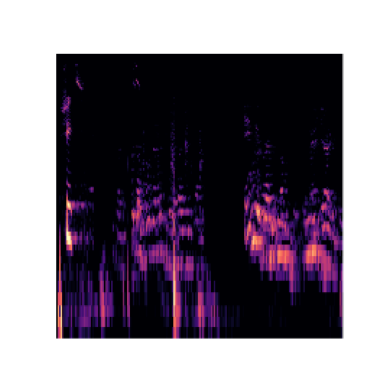

In [24]:
for specgrams, labels in test_ds:
    i = random.randint(0,batch_size)
    sample_specgram = specgrams[i].numpy().astype("uint8")
    label = class_names[labels[i]]

prediction = model.predict(sample_specgram.reshape(1,256,256,3), verbose=0)
prediction = tf.keras.layers.Softmax()(prediction)
prediction = class_names[np.argmax(prediction)]

print("GroundTruth: ", label)
print("Prediction : ", prediction)

plt.imshow(sample_specgram)
plt.axis("off")
plt.show()

In [25]:
# Save model
model.save("swear_detection_model.h5")

In [26]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Save the plots as images
plt.savefig('loss_and_accuracy_plots.png')

# Close the plots
plt.close()

1/1 [==============================] - 0s 33ms/step


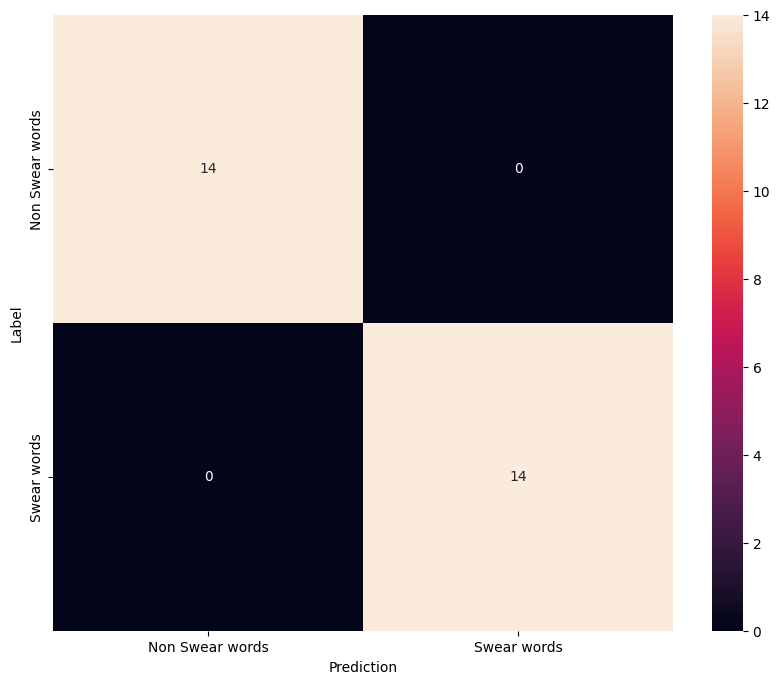

<Figure size 640x480 with 0 Axes>

In [29]:
y_pred = model.predict(test_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Save the confusion matrix as an image
plt.savefig('confusion_matrix.png')


In [ ]:
# # Convert the ground truth labels back to names
# y_true = np.concatenate([labels_batch for _, labels_batch in test_ds], axis=0)
# y_true = train_ds.class_names[y_true]

# # Obtain model predictions
# y_pred = model.predict(test_ds)
# y_pred = np.argmax(y_pred, axis=1)
# y_pred = train_ds.class_names[y_pred]

# # Compute the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


Bleep Out swear word

Recording audio

In [ ]:

# # Set duration and sampling rate
# duration = 5  # seconds
# sr = 44100  # sampling rate

# # Record audio
# print("Recording...")
# audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
# sd.wait()

# # Save audio to file
# librosa.output.write_wav('recorded_audio.wav', audio[:, 0], sr)
# print("Audio saved to file.")

#Load audio


Find Swear word location

In [ ]:
# # Load audio file
# #audio, sr = librosa.load('recorded_audio.wav', sr=44100)

# swear_word
# audio, sr = librosa.load()


# # Process audio file with swear detection model
# swear_model = swear_detection_model.h5 # Load or create your swear detection model
# swear_probabilities = swear_model.predict(audio)

# # Threshold the probabilities to get binary predictions
# swear_predictions = np.where(swear_probabilities > 0.5, 1, 0)

# # Find start and end times of swear word intervals
# swear_intervals = librosa.effects.split(audio, top_db=20)
# swear_intervals = [(start, end) for start, end in swear_intervals if np.any(swear_predictions[start:end])]

# # Print swear word intervals
# for start, end in swear_intervals:
#     print(f"Swear word detected from {start/sr:.2f}s to {end/sr:.2f}s")


Replace location where swear word found with bleep sound

In [ ]:
# !gdown https://drive.google.com/file/d/1FxtUibjVEqM1y1P_eXEjyiJ6lyuKYOFk/bleep.wav
# # Load bleep sound
# bleep, sr = librosa.load('bleep.wav', sr=44100)

# # Generate bleep sound of same length as swear word
# bleep_interval = np.zeros_like(swear_word)
# bleep_interval[:len(bleep)] = bleep

# # Replace swear word with bleep sound
# audio[swear_start:swear_end] = bleep_interval

# # Save modified audio file
# librosa.output.write_wav('output.wav', audio, sr)